In [16]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
mypath = 'Datos_Provs' #path with files to analyze
from matplotlib.ticker import AutoMinorLocator
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
from scipy.optimize import curve_fit

In [17]:
def get_Error(file_name):
    #error analysis, where file_name is the name of the file to analyze
    #i dont include mypath as an arg bc it's a global variable
    file_dir = mypath + '/' + str(file_name)
    data = pd.read_csv(file_dir,sep=",",quotechar='"',parse_dates=["fecha"],na_values=[''])
    df = pd.DataFrame(data)
    df.sort_values(by=["fecha"])
    #dates formatting
    first_day = min(df["fecha"])
    last_day = max(df["fecha"])
    df["fecha"] -= first_day
    df.fecha = df.fecha.dt.days
    df = df.groupby(["fecha"], as_index=False).mean()
    df = df.to_numpy() #to numpy array (date,rho7d,inc14days,riskper10)
    #data analysis per se
    last = df.shape[0]
    df = np.hstack((df,np.zeros((last,1))))
    i = 19
    while i < last:
        df[i,4] = df[i-7,3]
        i = i+1
    error = abs(df[19:,4]-df[19:,2])
    return error,df[19:,1]

In [18]:
#apparently theres like no function to make this thing i want
def make_hist(file_name,error,r_seven,bs,loc=2,save=False):
    error = error[:-10]
    r_seven = r_seven[:-10]
    error = abs(error)
    max_v = round(max(r_seven),1) 
    min_v = round(min(r_seven),1)
    r_bins = np.arange(min_v,max_v+bs,bs) #bin range
    rr_bins = np.arange(min_v,max_v+bs,bs*loc) #the loc factor comes into pay here
    n_size = r_bins.shape[0]-1 #amount of bins
    c_bins = np.zeros(n_size) #center of bins
    e_bins = np.zeros(n_size) #errors with same size
    std_bins = np.zeros(n_size) #std of bins 
    o_bins = np.zeros(n_size) #amount of observations for that bin
    i = 0 #this is just a counter
    #now we count for each bin based on error
    cuenta = 0
    while i < n_size:
        indices1 = ((i*bs)+min_v<=r_seven)
        indices2 = (r_seven < min_v + (i+1)*bs)
        indices = indices1*indices2
        errores = np.copy(error[indices])
        cuenta = errores.shape[0]
        if errores.size == 0:
            m_errores = 0
            m_std = 0
        else:
            m_errores = np.mean(errores)
            m_std = np.std(errores)/cuenta
        e_bins[i] = m_errores
        std_bins[i] = m_std
        o_bins[i] = cuenta
        c_bins[i] = (2*i+1)*(bs/2) + min_v
        i = i +1
    plt.figure()
    plt.title(str(file_name)+' - Error-R7 - bs = 0.2')
    ax = plt.axes()
    ax.set_xticks(rr_bins)
    ax.set_xticklabels(())
    ax.set_xticklabels((rr_bins.round(2)))
    plt.xlabel(r'$R_7$',fontsize=12)
    plt.ylabel('Error',fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2)) #for minor ticks to be visible its the easiest i could find tbh
    plt.xticks(fontsize=12,rotation=90)
    plt.grid()
    plt.bar(c_bins, e_bins, bs, color='r',edgecolor='k',yerr=std_bins)
    plt.savefig('Hist_nue_13nov/'+str(file_name)+'_Hist.pdf')
    plt.show()
    return c_bins,e_bins,std_bins,o_bins

In [19]:
def chunks(lst,a,n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n],a[i:i + n]

In [66]:
#new hist with a much better approach and easier and faster
def new_hist(file_name,error,r_seven,bs,loc=2,save=False):
    error = error[:-10]
    r_seven = r_seven[:-10]
    #indices = (r_seven <= 2)
    #r_seven = r_seven[indices]
    #error = error[indices]
    error = abs(error)
    r_sevens, errores= (list(t) for t in zip(*sorted(zip(r_seven, error)))) #ordeno por orden del r_seven
    hist_graf = [] #minimos y maximos consecutivos
    c_bins = []
    e_bins = []
    std_bins = []
    obs_bins = []
    x = chunks(r_sevens,errores,bs)
    for i in x:
        rs = i[0]
        es = i[1]
        hist_graf.append(min(rs))
        hist_graf.append(max(rs))
        c_bins.append(np.mean(rs))
        e_bins.append(np.mean(es))
        obs_bins.append(len(es))
        std_bins.append(np.std(es)/len(es))
    plt.errorbar(c_bins,e_bins,yerr=std_bins,fmt='-ob')
    y_min, y_max = plt.gca().get_ylim()
    plt.title(str(file_name)+' - Error-R7 - obs = 20')
    grouped_lists = [hist_graf[n:n+2] for n in range(0, len(hist_graf), 2)]
    i = 0
    for g in grouped_lists:
        plt.axvspan(g[0],g[1],facecolor='r',edgecolor='k',alpha=0.5)
        i = i + 1
    plt.savefig('Hist_nue_13nov/'+str(file_name)+'_Hist_2.pdf')
    plt.show()
    return c_bins,e_bins,std_bins,obs_bins

In [21]:
#grafico log-log
def graph_loglog(b_centers,b_errors,b_std,file_name):
    #save_data(b_centers,b_errors,c_obs,'BuenosAires_hist_2')
    b_centers = b_centers[b_errors!=0]
    b_std = b_std[b_errors!=0]
    b_errors = b_errors[b_errors!=0]
    max_errors = np.argmax(b_errors)
    max_rseven = b_centers[max_errors]
    #separo a un lado
    b_centers_1 = b_centers[:max_errors]
    b_errors_1 = b_errors[:max_errors]
    b_std_1 = b_std[:max_errors]
    #separo al otro lado
    b_centers_2 = b_centers[max_errors:]
    b_errors_2 = b_errors[max_errors:]
    b_std_2 = b_std[max_errors:]
    #imprimo a ver si esta bien
    print(b_centers_1,b_centers_2)
    #grafico
    plt.errorbar(np.log(np.abs(b_centers_1-1)),np.log(b_errors_1),yerr=b_std_1,label='left',fmt='-o')
    plt.errorbar(np.log(np.abs(b_centers_2-1)),np.log(b_errors_2),yerr=b_std_2,label='right',fmt='-o')
    plt.xlabel(r'$log|R_7 - 1|, R_7 max = $'+str(max_rseven))
    plt.ylabel(r'log|Error|')
    plt.legend()
    plt.grid()
    plt.savefig('Hist_nue_13nov/'+str(file_name)+'_LogLog_2.pdf')
    plt.show()

In [22]:
def save_data(b_centers,b_errors,b_std,c_obs,string):
    matriz = np.zeros((len(c_obs),4))
    matriz[:,0] = b_centers
    matriz[:,1] = b_errors
    matriz[:,2] = b_std
    matriz[:,3] = c_obs
    np.savetxt(string+'.txt',matriz,delimiter=',',header='Bin Centers,Abs Mean Error,Mean SE,Observations')

# grafico aca el tema de los errores - func de R7 (log-log)

In [8]:
def exponential(x,a,b):
    return a*(x**b)

# todos los graficos nuevos

# los histogramas comunes

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


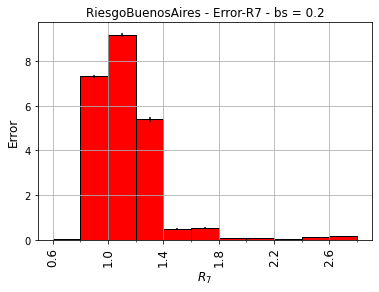

[0.7 0.9] [1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7]


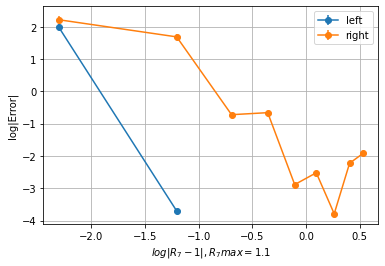

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


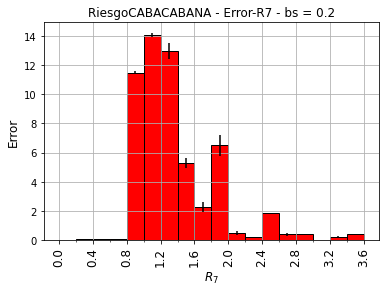

[0.3 0.5 0.7 0.9] [1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.3 3.5]


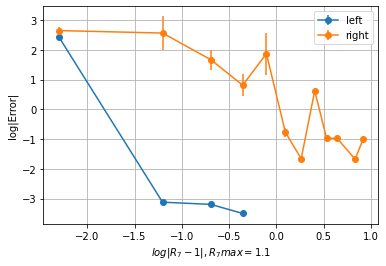

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


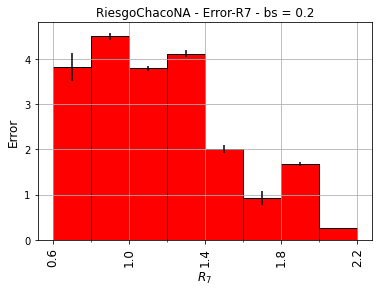

[0.7] [0.9 1.1 1.3 1.5 1.7 1.9 2.1]


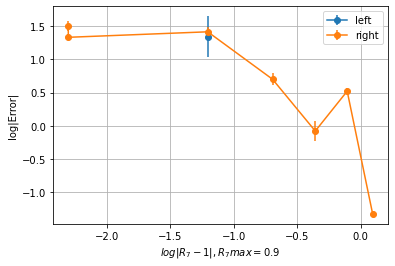

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


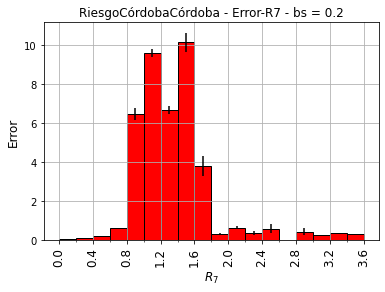

[0.1 0.3 0.5 0.7 0.9 1.1 1.3] [1.5 1.7 1.9 2.1 2.3 2.5 2.9 3.1 3.3 3.5]


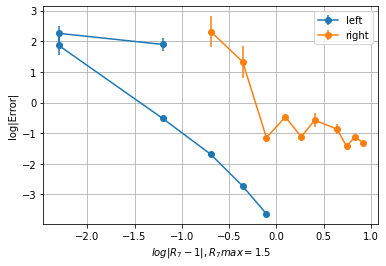

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


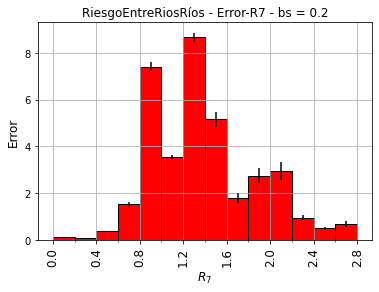

[0.1 0.3 0.5 0.7 0.9 1.1] [1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7]


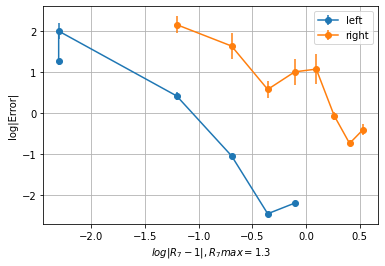

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


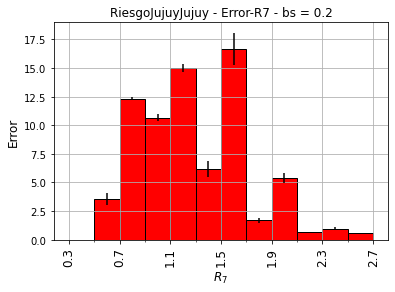

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


[0.6 0.8 1.  1.2 1.4] [1.6 1.8 2.  2.2 2.4 2.6]


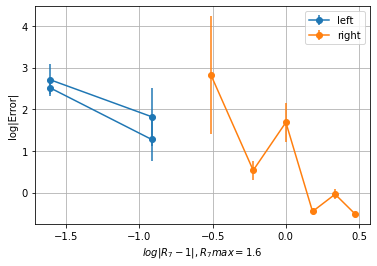

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


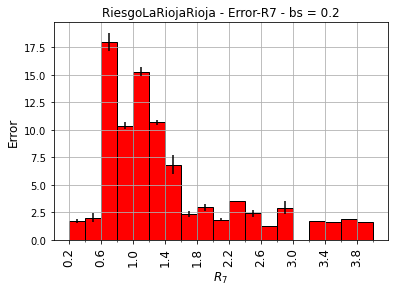

[0.3 0.5] [0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.3 3.5 3.7 3.9]


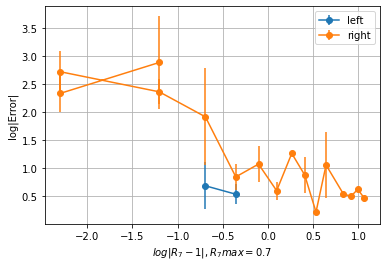

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


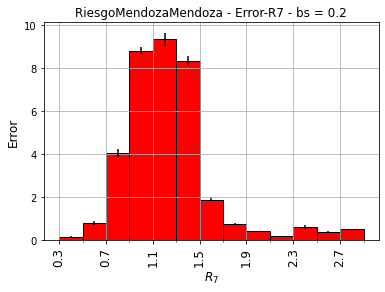

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


[0.4 0.6 0.8 1. ] [1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8]


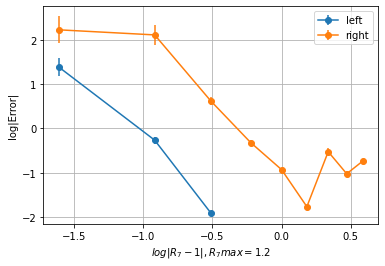

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


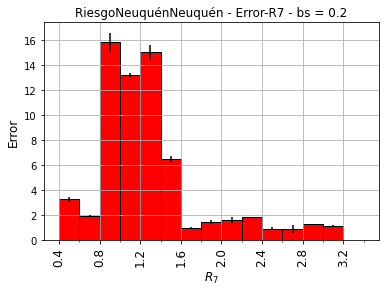

[0.5 0.7] [0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1]


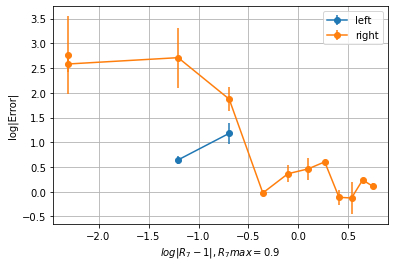

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


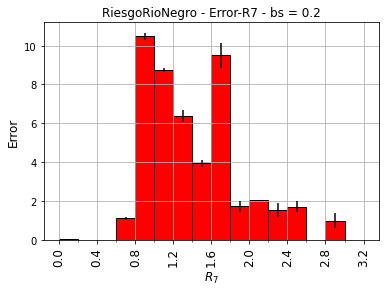

[0.1 0.7] [0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.9]


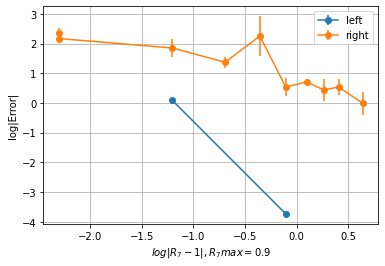

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


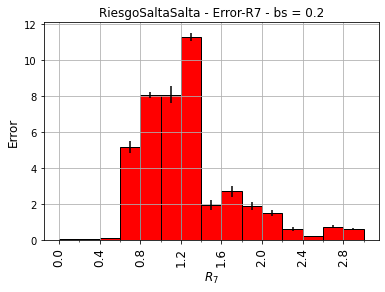

[0.1 0.3 0.5 0.7 0.9 1.1] [1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]


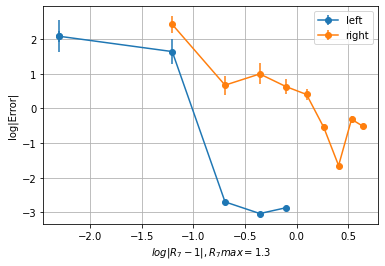

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


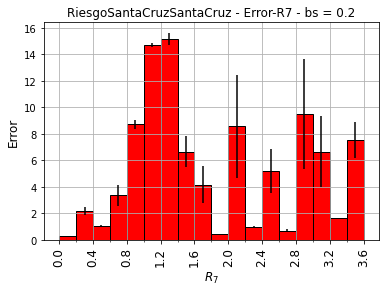

[0.1 0.3 0.5 0.7 0.9 1.1] [1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5]


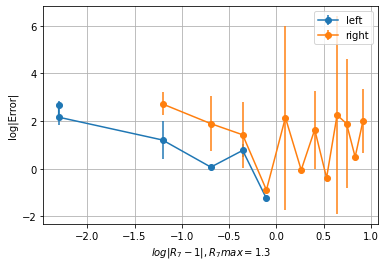

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


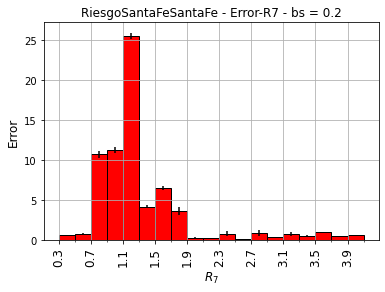

[0.4 0.6 0.8 1. ] [1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4. ]


C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


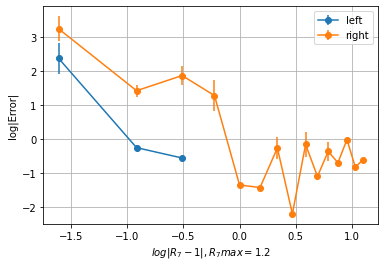

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


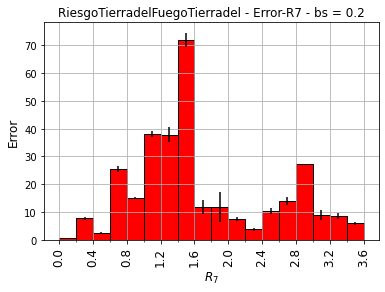

[0.1 0.3 0.5 0.7 0.9 1.1 1.3] [1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5]


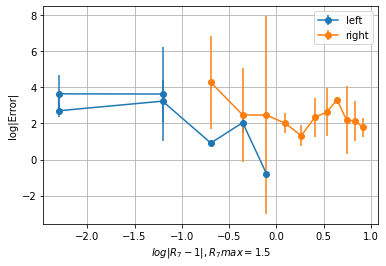

C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


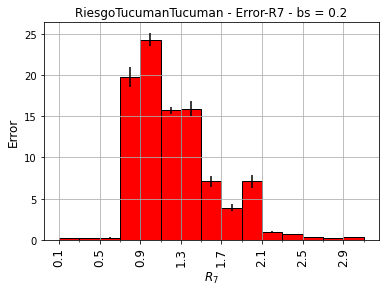

[0.2 0.4 0.6 0.8] [1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3. ]


C:\Users\denis\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


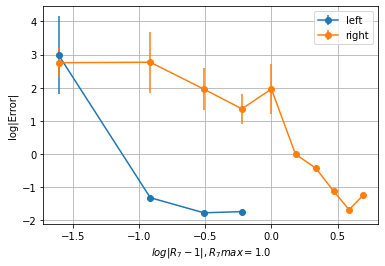

In [15]:
for file in files:
    bs = 0.2
    file_name = file
    error,r_seven = get_Error(file_name)
    b_centers,b_errors,b_std,c_obs = make_hist(file_name,error,r_seven,bs,loc=2) 
    #save_data(b_centers,b_errors,b_std,c_obs,file_name)
    graph_loglog(b_centers,b_errors,b_std,file_name)

# los histogramas nuevos

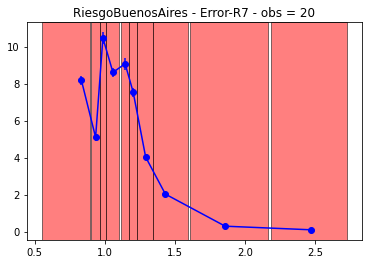

[0.83363889 0.93482584] [0.98685429 1.05856827 1.14531023 1.20305172 1.29205593 1.43280763
 1.8593045  2.47473958]


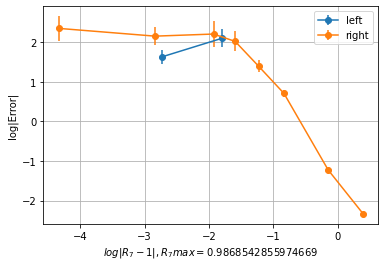

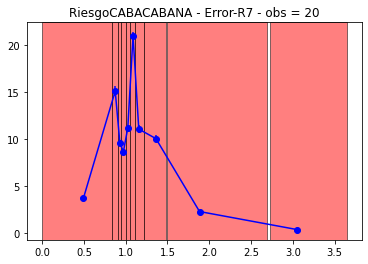

[0.49311161 0.87430829 0.93036348 0.9726537  1.02477409] [1.08757938 1.15633827 1.36150252 1.88345161 3.05079055]


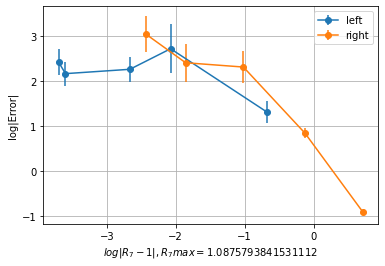

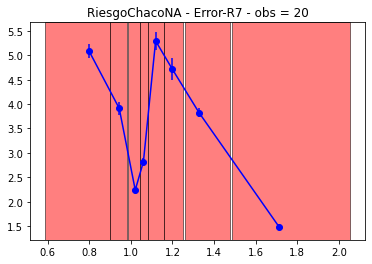

[0.79923991 0.9439293  1.02086807 1.06021115] [1.11891403 1.1992606  1.32737405 1.71323459]


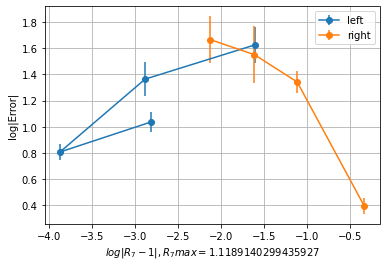

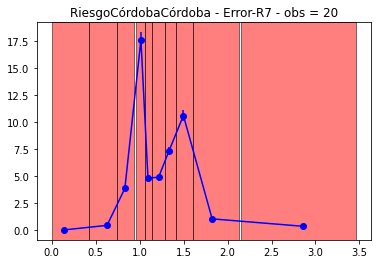

[0.14095769 0.6283252  0.83112927] [1.01412922 1.09397179 1.21528582 1.33412304 1.49730261 1.82420828
 2.86068865]


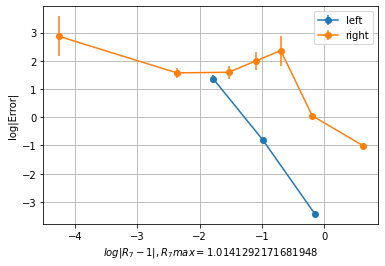

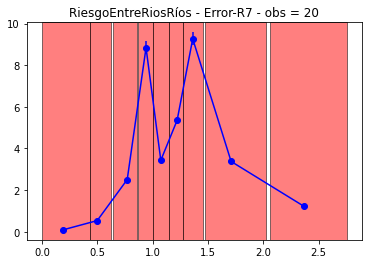

[0.18825397 0.49758204 0.76873737 0.93884374 1.07238346 1.21988104] [1.36086229 1.70791136 2.36718846]


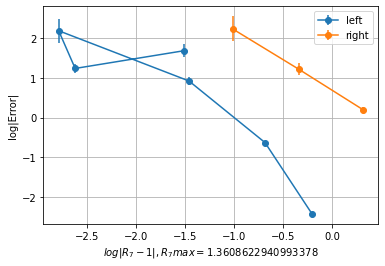

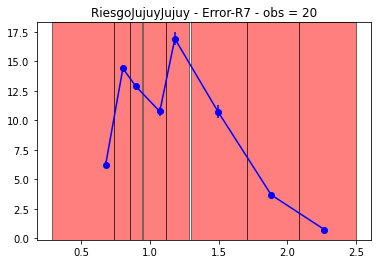

[0.67757435 0.80285613 0.89590137 1.07140163] [1.18090698 1.49490595 1.88181583 2.26829953]


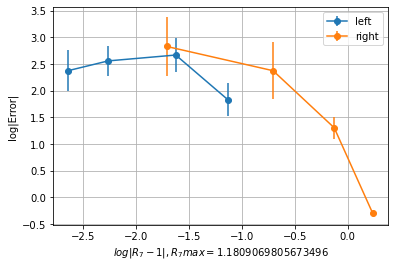

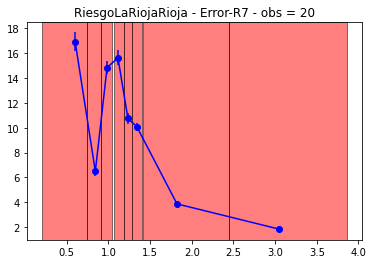

[] [0.60055926 0.84265146 0.98348073 1.11435192 1.2336101  1.34008803
 1.82259598 3.04674583]


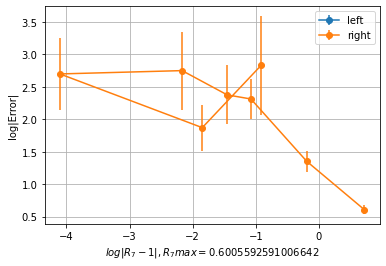

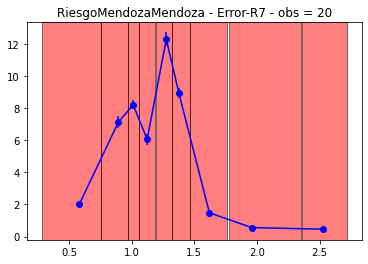

[0.58226811 0.89419858 1.01179812 1.12327852] [1.27636821 1.37709409 1.62004619 1.95834967 2.52423687]


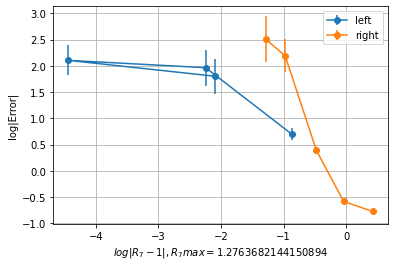

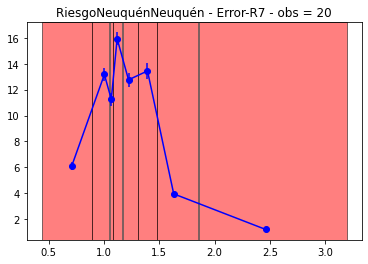

[0.70755036 1.00329714 1.06572013] [1.11870925 1.22171771 1.39330837 1.63044892 2.46103573]


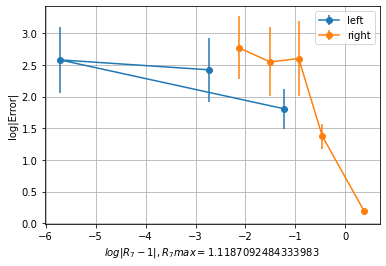

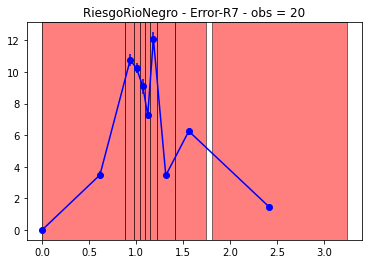

[0.         0.61449058 0.93639273 1.00372411 1.0702952  1.12309842] [1.18334128 1.3152849  1.55996578 2.41251301]


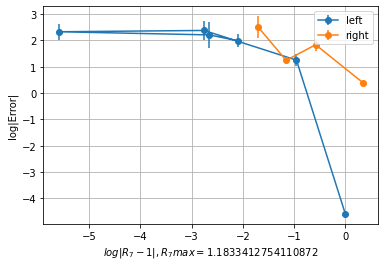

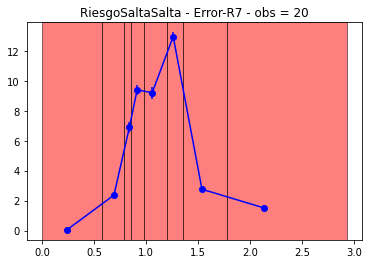

[0.23809524 0.69075631 0.8391379  0.91352517 1.05837302] [1.26068739 1.5373433  2.13071347]


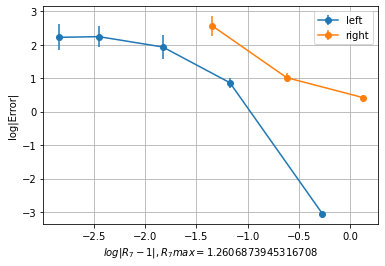

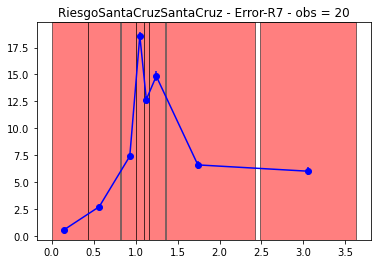

[0.15095238 0.56539195 0.93001782] [1.04965625 1.12712687 1.24555978 1.74191345 3.06084069]


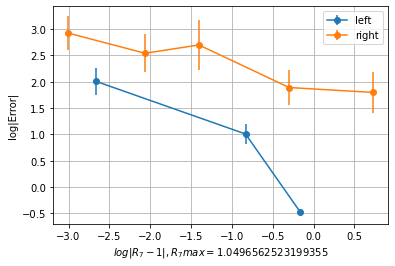

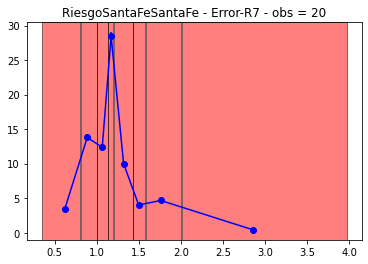

[0.61628936 0.88500297 1.06314178] [1.16865166 1.31695895 1.49615133 1.75798695 2.85508541]


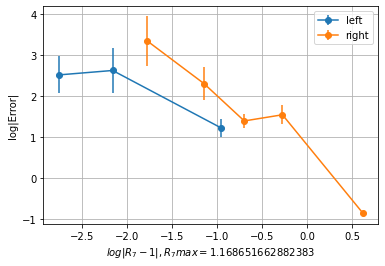

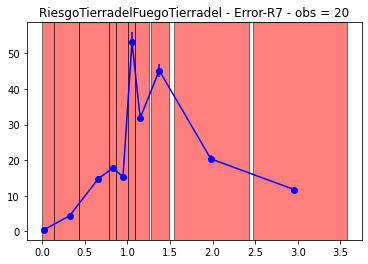

[0.01904762 0.32175708 0.65790729 0.83027148 0.94812003] [1.05403627 1.15010117 1.37399409 1.97900924 2.95674866]


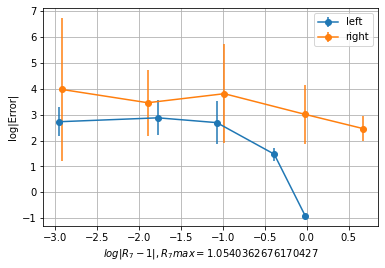

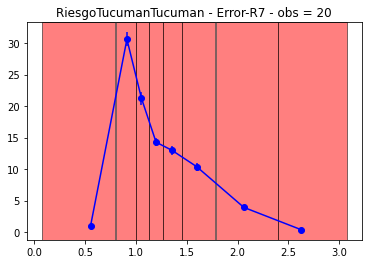

[0.55260216] [0.91017097 1.05285643 1.19709814 1.3538801  1.59632531 2.06080203
 2.62518153]


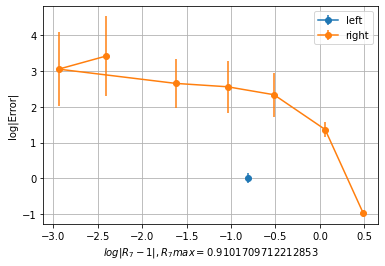

In [67]:
for file in files:
    bs = 30
    file_name = file
    error,r_seven = get_Error(file_name)
    c_bins,e_bins,std_bins,obs_bins = new_hist(file_name,error,r_seven,bs,loc=2)
    graph_loglog(np.array(c_bins),np.array(e_bins),np.array(std_bins),file_name)